##Image Classification using Feedforward Networks in Keras
 we will see how to classify hand-written digits from the MNIST dataset using a feed forward Multilayer Perceptron Network. MLP's are not the preferred way to process image data, but this serves as a good example to introduce some new concepts.
The MNIST hand-written digit dataset is included in Tensorflow and can easily be imported and loaded
<img src="https://learnopencv.com/wp-content/uploads/2023/01/keras-mnist-digits-classification.png">
using this dataset and a simple feed-forward network, we will demonstrate one approach for how to work with image data and build a network classifies digits [0, 9]


In [1]:
#importing new packages
import random
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [2]:
#plt parameters
plt.rcParams["axes.titlesize"] = 16
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["image.cmap"] = "gray"

In [3]:
SEED_VALUE = 42

#fix seed to make training deterministic
random.seed(SEED_VALUE)
np.random.seed(SEED_VALUE)
tf.random.set_seed(SEED_VALUE)

###Load and split the MNIST Dataset
MNIST dataset contains 70,000 images partitioned into 60,000 for training and 10,000 for test.

In [4]:
(X_train_all, y_train_all),(X_test, y_test) = mnist.load_data()

X_valid = X_train_all[:10000]
X_train = X_train_all[10000:]

y_valid = y_train_all[:10000]
y_train = y_train_all[10000:]

print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
(50000, 28, 28)
(10000, 28, 28)
(10000, 28, 28)


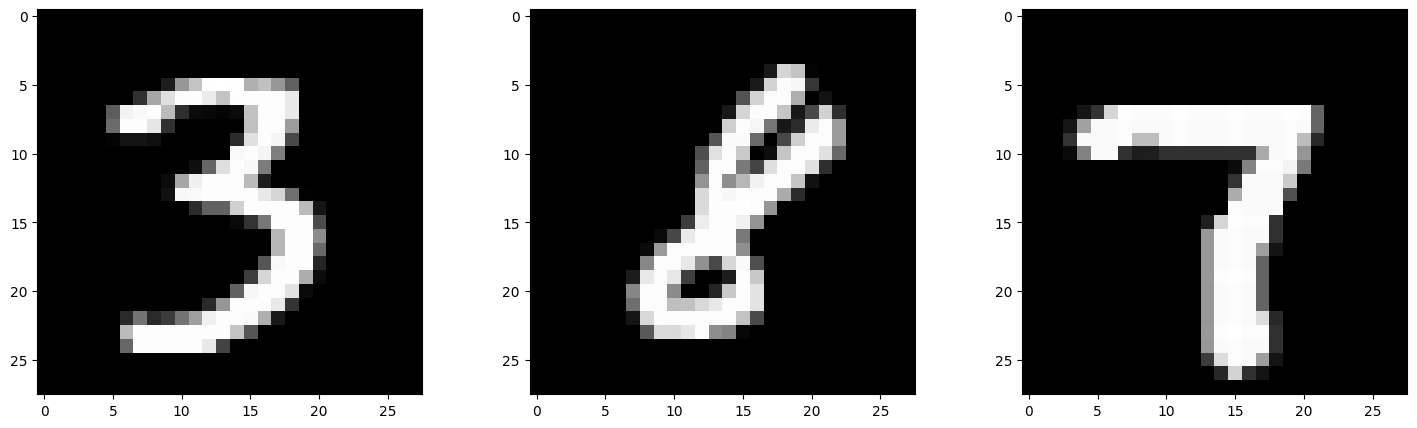

In [5]:
plt.figure(figsize=(18, 5))
for i in range(3):
  plt.subplot(1, 3, i+1)
  plt.axis(True)
  plt.imshow(X_train[i], cmap="gray")
  plt.subplots_adjust(wspace=0.2, hspace=0.2)

###Dataset Preprocessing
####Input Feature Transformation and Normalization
we are now working with images as the input, we need to find some logical way to represent the image data as a set of features. And one way to transform the image data into a set features that we can process is to flatten the 2D array into a 1D array. The 28x28 input image thus becomes a 1D array containing 784 features. Notice that we also normalize the pixel intensities to be in the range [0, 1]. This is very common when working with image data which helps the model train more efficiently. This is very common when working with image data which helps the model train more, and also using the pixel intensities as features is a naive approach that for keep things simple, and we will learn about Convolutional Neural Networks(CNNs), which use more advanced techniques for representing and processing image data in neural networks

In [6]:
X_train = X_train.reshape((X_train.shape[0], 28*28))
X_train = X_train.astype("float32") / 255

X_test = X_test.reshape((X_test.shape[0], 28*28))
X_test = X_test.astype("float32") / 255

X_valid = X_valid.reshape((X_valid.shape[0], 28*28))
X_valid = X_valid.astype("float32") / 255

##Label Encoding Options
we have many options for label encoding, for this we are going to <b>Integer Encoding</b> where an integer is assigned to each class, or we can use the technique <b>One-Hot Encoding</b> which uses a seperate binary vectorto encode each class label

We are going to use fashion_model dataset for <b>Integer Encoding</b>

In [7]:
from tensorflow.keras.datasets import fashion_mnist

#loading the MNIST fashion dataset
((X_train_fashion, y_train_fashion), (_, _)) = fashion_mnist.load_data()

#the labels in the fashion MNIST dataset are encoded as integers
print(y_train_fashion[0:9])

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
[9 0 0 3 0 2 7 2 5]


##One Hot Label Encoding
for one hot label encoding <code>to_categorical()</code> function in keras as a preprocessing step


In [8]:
y_train_onehot = to_categorical(y_train_fashion[0:9])

print(y_train_onehot)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [9]:
#convert integer labels to one-hot encoded layers
y_train = to_categorical(y_train)
y_valid = to_categorical(y_valid)
y_test = to_categorical(y_test)

###Model Architecture
Deep Neural Network Architecture
<image src="https://learnopencv.com/wp-content/uploads/2023/01/keras-mnist-mlp-network.png">
1. Input Data: The image input data is pre-processed (flattened) from a 2D to 1D
2. Hidden layers: we have two hidden layers that contain some number of neurons(that we need to specify) each of the neurons in the layer has a non-linear activation function (eg: ReLU, Sigmoid, etc)
3. Output Layer: we now have ten neurons in the output layer to represent the ten different classes (digits 0 to 9) instead of a single neuron as in the regression example.
4. Dense Layers: all the layers in the network are connected that each neuron in a given layer is fully connected (or dense) to each of the neurons in the previous layer.
5. Softmax Function: the values from each of the neurons in the output layer are passed through a softmax function to produce a probability score for each of the ten digits in the dataset
6. Network Output: The network output is a vector of the length ten that contains the probabilities of each output neuron.
7. Loss function: The loss function used is <b>Cross Entropy Loss</b>. which is generally the preferred loss function or classification problems.

In [10]:
#Define the model
model = tf.keras.Sequential()

#build the model
model.add(Dense(128, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(128, activation='relu'))
model.add(Dense(10, activation="softmax"))

#display the model summary
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         100,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 10)                  │           1,290 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,282 (462.04 KB)

 Trainable params: 118,282 (462.04 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
#compile the model
#rmsprop - for accuracy
#categorical_crossentropy - for loss function
#in metrics we specify accuracy as an additional metric to record during training so we can plot it after training completed
model.compile(
    optimizer="rmsprop",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [12]:
#train the model
training_results = model.fit(X_train, y_train,
                             epochs=21,
                             batch_size=64, validation_data=(X_valid, y_valid))

Epoch 1/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.8643 - loss: 0.4780 - val_accuracy: 0.9450 - val_loss: 0.1755
Epoch 2/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.9601 - loss: 0.1360 - val_accuracy: 0.9606 - val_loss: 0.1299
Epoch 3/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9746 - loss: 0.0893 - val_accuracy: 0.9658 - val_loss: 0.1137
Epoch 4/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9814 - loss: 0.0649 - val_accuracy: 0.9691 - val_loss: 0.1105
Epoch 5/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - accuracy: 0.9863 - loss: 0.0487 - val_accuracy: 0.9715 - val_loss: 0.1104
Epoch 6/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - accuracy: 0.9894 - loss: 0.0385 - val_accuracy: 0.9717 - val_loss: 0.1157
Epoch 7/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9921 - loss: 0.0293 - val_accuracy: 0.9692 - val_loss: 0.1311
Epoch 8/21
782/782 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.9935 - loss: 0.0243 - val_accuracy: 0.

In [13]:
#plot the training results
def plot_results(metrics, title=None, ylabel=None, ylim=None, metric_name=None, color=None):

    fig, ax = plt.subplots(figsize=(15, 4))

    if not (isinstance(metric_name, list) or isinstance(metric_name, tuple)):
        metrics = [metrics,]
        metric_name = [metric_name,]

    for idx, metric in enumerate(metrics):
        ax.plot(metric, color=color[idx])

    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xlim([0, 20])
    plt.ylim(ylim)
    # Tailor x-axis tick marks
    ax.xaxis.set_major_locator(MultipleLocator(5))
    ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
    ax.xaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(True)
    plt.legend(metric_name)
    plt.show()
    plt.close()

In [14]:
#retrieve training results
#for this we use history object
train_loss = training_results.history["loss"]
train_acc = training_results.history["accuracy"]
valid_loss = training_results.history["val_loss"]
valid_acc = training_results.history["val_accuracy"]

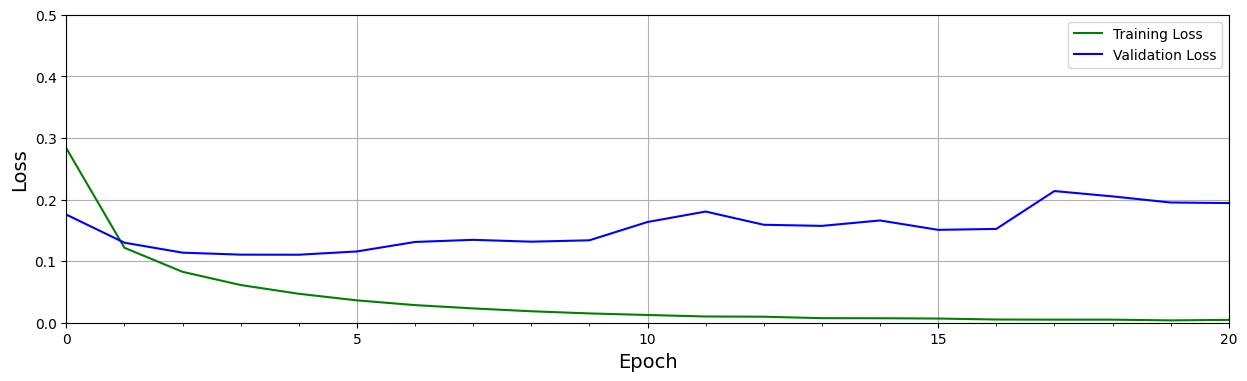

In [15]:
#using plot result function for Loss graphical representation
plot_results([train_loss, valid_loss],
             ylabel="Loss",
             ylim=[0.0, 0.5],
             metric_name=["Training Loss", "Validation Loss"],
             color=["g", "b"])

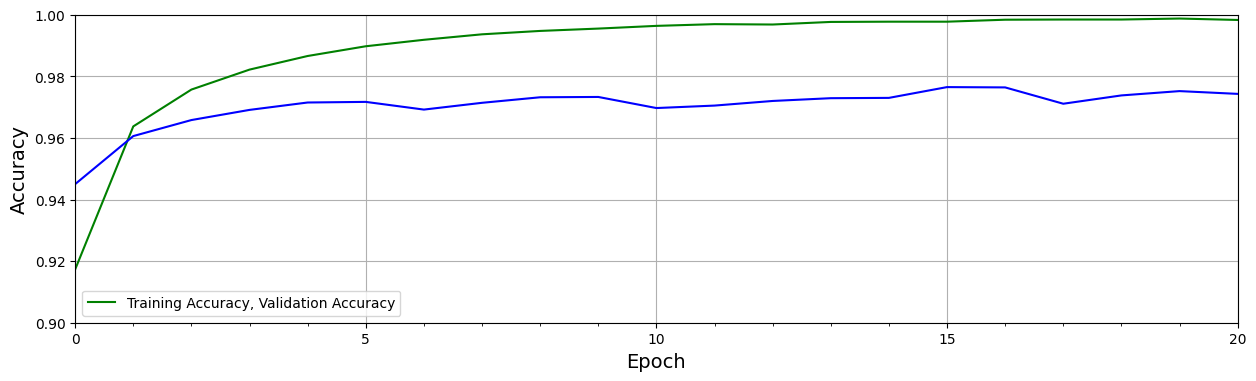

In [16]:
#accuracy graph
plot_results(
    [train_acc, valid_acc],
    ylabel="Accuracy",
    ylim=[0.9, 1.0],
    metric_name=["Training Accuracy, Validation Accuracy"],
    color=["g", "b"]
)

In [17]:
#making predictions on sample test images
predictions = model.predict(X_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [18]:
index = 0 #upto 9999
print("Ground truth for test digit: ",y_test[index])
print("Predictions for each class: ")
for i in range(10):
  print("digit:",i,"probaility: ",predictions[index][i])

Ground truth for test digit:  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Predictions for each class: 
digit: 0 probaility:  8.729837e-25
digit: 1 probaility:  3.617277e-21
digit: 2 probaility:  3.460681e-17
digit: 3 probaility:  6.1899135e-16
digit: 4 probaility:  8.43316e-30
digit: 5 probaility:  5.053907e-25
digit: 6 probaility:  2.6305837e-36
digit: 7 probaility:  0.99999994
digit: 8 probaility:  2.8177708e-22
digit: 9 probaility:  4.4525763e-18


###Confusion matrix
confusion matrix is a very common metric that is used to summarize the results of the classification problem. the information is presented in the form of a table or matrix where one axis represents the grounf truth labels for each class, and the other axis represnts the predicted labels from the network.
for confusion matrix tensorflow has own function <code>tf.math.confusion_matrix()</code>

In [19]:
#generate predictions for the test dataset
predictions = model.predict(X_test)

#for each sample image in the test dataset, select the class label with the highest probability
predicted_labels = [np.argmax(i) for i in predictions]

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [20]:
#converting one-hot encoded labels to integers
y_test_integer_labels = tf.argmax(y_test, axis=1)

#geneating a confusion matrix for the text dataset
cm = tf.math.confusion_matrix(labels=y_test_integer_labels, predictions=predicted_labels)

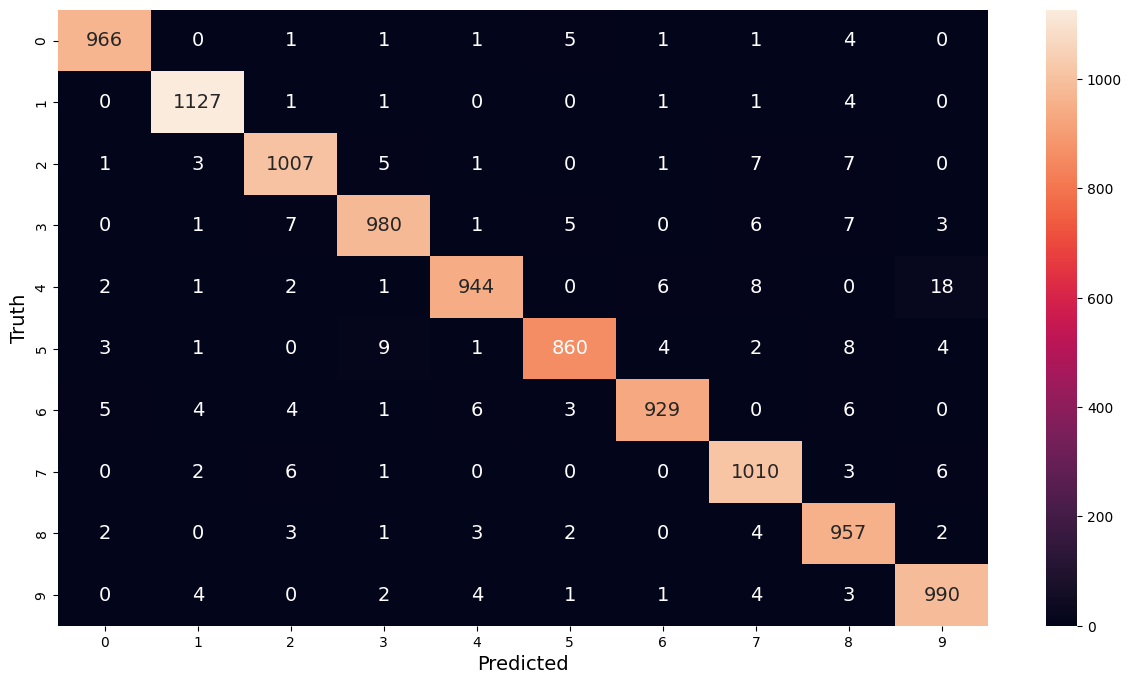

In [21]:
#plot the confusion matrix as a heatmap
import seaborn as sn

plt.figure(figsize=[15, 8])
sn.heatmap(cm, annot=True, fmt="d", annot_kws={"size":14})
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()